La empresa Zyfra del ámbito de la minería del oro, requiere un modelo para predecir la cantidad de oro extraído del mineral de oro, considerando que tanto el concentrado final como el concentrado rougher tienen importancia, son estas dos variables las que se requieren predecir.

**Prepara los datos**

**1.1.** Abre los archivos y examina los datos.

In [44]:
#Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit

In [45]:
#Definir ruta de los archivos

archivo_entrenamiento = "/datasets/gold_recovery_train.csv"
archivo_prueba = "/datasets/gold_recovery_test.csv"
archivo_fuente = "/datasets/gold_recovery_full.csv"

archivos = {
    "Dataset entrenamiento": archivo_entrenamiento,
    "Dataset prueba": archivo_prueba,
    "Dataset fuente": archivo_fuente}

In [46]:
#Cargar datos

def cargar_archivos (archivo,archivo_nombre):
    print(f"\n-----Informarción del {archivo_nombre}:")
    df = pd.read_csv(archivo)
    df_info=df.info()
    print(f"\n---Primeras filas del {archivo_nombre}:")
    print(df.head())
    print(f"\n---Número de filas duplicadas del {archivo_nombre}:")
    print(df.duplicated().sum())
    print(f"\n---nTotal de valores ausentes en el dataset {archivo_nombre}:")
    print(df.isnull().sum())
    return df
    
for nombre, archivo in archivos.items():
    cargar_archivos(archivo, nombre) 


-----Informarción del Dataset entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol         

*Observaciones:*
- Todos los datasets presentan datos ausentes, pero como la cantidad es reducida, es posible eliminarlos y que no afecte en la realización del modelo.
- Para columna "Date" debe cambiarse el tipo de dato

In [47]:
#Limpieza de datos

dataframes = {}

def limpiar_archivos (archivo,archivo_nombre):
    df = pd.read_csv(archivo)
    df = df.dropna()
    df['date'] = pd.to_datetime(df["date"], errors="coerce")
    print(f"\n-----Informarción del {archivo_nombre}:")
    df_info=df.info()
    dataframes[archivo_nombre] = df

for nombre, archivo in archivos.items():
    limpiar_archivos(archivo, nombre) 



-----Informarción del Dataset entrenamiento:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                11017 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         11017 non-null  float64       
 2   final.output.concentrate_pb                         11017 non-null  float64       
 3   final.output.concentrate_sol                        11017 non-null  float64       
 4   final.output.concentrate_au                         11017 non-null  float64       
 5   final.output.recovery                               11017 non-null  float64       
 6   final.output.tail_ag                                11017 non-null  float64       
 7   final.output.tail_pb                            

**1.2.** Comprueba que el cálculo de la recuperación sea correcto. Calcula la recuperación de la característica rougher.output.recovery mediante el conjunto de entrenamiento. Encuentra el EAM entre tus cálculos y los valores de la característica. Facilita los resultados.

In [48]:
#Asignación de DataFrames

df_entrenamiento = dataframes["Dataset entrenamiento"]
df_prueba = dataframes["Dataset prueba"]
df_fuente = dataframes["Dataset fuente"]

In [49]:
from sklearn.metrics import mean_absolute_error 

# Variables necesarias
F = df_entrenamiento['rougher.input.feed_au']
C = df_entrenamiento['rougher.output.concentrate_au']
T = df_entrenamiento['rougher.output.tail_au']
recovery_real = df_entrenamiento['rougher.output.recovery']

# Cálculo de recuperación
df_entrenamiento['recovery_calc'] = (C * (F - T)) / (F * (C - T)) * 100

# Cálculo del Error Absoluto Medio
EAM = mean_absolute_error(df_entrenamiento['recovery_calc'],recovery_real)

print(EAM)

9.460144184559453e-15


El EAM es extremadamente pequeño, lo que indica que las columnas con prácticamente iguales, es decir, no hay diferencias significativas.

**1.3.** Analiza las características no disponibles en el conjunto de prueba. ¿Cuáles son estos parámetros? ¿Cuál es su tipo?

In [50]:
# Obtener las columnas de cada dataset
columnas_entrenamiento = set(df_entrenamiento.columns)
columnas_prueba = set(df_prueba.columns)

print(f"Columnas en entrenamiento: {len(columnas_entrenamiento)}")
print(f"Columnas en prueba: {len(columnas_prueba)}")

Columnas en entrenamiento: 88
Columnas en prueba: 53


In [51]:
# Obtener las características faltantes
caracteristicas_faltantes = columnas_entrenamiento - columnas_prueba

print("Características no disponibles en el conjunto de prueba:")
print(f"Total: {len(caracteristicas_faltantes)}\n")

# Clasificar por tipo de parámetro
tipos_parametros = {
    'recovery': [],
    'concentrate': [],
    'tail': [],
    'otros': []
}

for caracteristica in sorted(caracteristicas_faltantes):
    if 'recovery' in caracteristica:
        tipos_parametros['recovery'].append(caracteristica)
    elif 'concentrate' in caracteristica:
        tipos_parametros['concentrate'].append(caracteristica)
    elif 'tail' in caracteristica:
        tipos_parametros['tail'].append(caracteristica)
    else:
        tipos_parametros['otros'].append(caracteristica)

# Mostrar resultados por categoría
for tipo, parametros in tipos_parametros.items():
    if parametros:
        print(f"\n{tipo.upper()} ({len(parametros)} parámetros):")
        for param in parametros:
            print(f"  - {param}")

Características no disponibles en el conjunto de prueba:
Total: 35


RECOVERY (3 parámetros):
  - final.output.recovery
  - recovery_calc
  - rougher.output.recovery

CONCENTRATE (13 parámetros):
  - final.output.concentrate_ag
  - final.output.concentrate_au
  - final.output.concentrate_pb
  - final.output.concentrate_sol
  - primary_cleaner.output.concentrate_ag
  - primary_cleaner.output.concentrate_au
  - primary_cleaner.output.concentrate_pb
  - primary_cleaner.output.concentrate_sol
  - rougher.calculation.sulfate_to_au_concentrate
  - rougher.output.concentrate_ag
  - rougher.output.concentrate_au
  - rougher.output.concentrate_pb
  - rougher.output.concentrate_sol

TAIL (16 parámetros):
  - final.output.tail_ag
  - final.output.tail_au
  - final.output.tail_pb
  - final.output.tail_sol
  - primary_cleaner.output.tail_ag
  - primary_cleaner.output.tail_au
  - primary_cleaner.output.tail_pb
  - primary_cleaner.output.tail_sol
  - rougher.output.tail_ag
  - rougher.output.tail_au


Hay mediciones ausentes en el conjunto de prueba porque fueron medidos mucho más tarde, esto se debe a que en el proceso de flotación de oro, las mediciones se toman en distintos momentos. Se miden al inicio del proceso las variables de entrada, las cuales se encuentran en ambos dataset, sin embargo, las variables que se miden después de completar el proceso se encuentran solo en el dataset de entrenamiento.

Ahora, para hacer predicciones no se necesitan todas estas variables para hacer predicciones; es posible entrenar el modelo solo usando las características disponibles en ambos conjuntos (variables de entrada) para predecir las variables objetivo: rougher.output.recovery y final.output.recovery

**1.4.** Realiza el preprocesamiento de datos.

In [52]:
# Características disponibles en ambos conjuntos
caracteristicas_validas = columnas_entrenamiento.intersection(columnas_prueba)
print(f"Características válidas para entrenar: {len(caracteristicas_validas)}")

Características válidas para entrenar: 53


In [53]:
# Filtrar df_prueba para conservar solo las columnas que también están en df_entrenamiento
df_prueba_filtrado = df_prueba[columnas_entrenamiento.intersection(df_prueba.columns)]
df_prueba_filtrado.head()

,rougher.input.feed_au,rougher.state.floatbank10_d_air,primary_cleaner.input.xanthate,rougher.state.floatbank10_c_level,secondary_cleaner.state.floatbank5_b_level,rougher.state.floatbank10_a_air,date,rougher.state.floatbank10_a_level,primary_cleaner.state.floatbank8_c_level,secondary_cleaner.state.floatbank4_a_air,...,rougher.input.floatbank11_sulfate,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank6_a_level,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate,secondary_cleaner.state.floatbank3_b_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.input.feed_size,secondary_cleaner.state.floatbank2_b_level,primary_cleaner.state.floatbank8_d_level
0,12.084103,1198.287855,1.005021,-399.396730,-500.037437,1001.849317,2016-09-01 00:59:59,-350.301265,-500.704369,12.023554,...,16.867518,-450.395995,-499.709414,6.153479,6.150709,-449.831513,1399.144926,8.080000,-500.013837,-499.485144
1,11.918977,1200.506459,0.990469,-399.630810,-500.162375,998.690785,2016-09-01 01:59:59,-350.425704,-499.240168,12.058140,...,16.996063,-450.114024,-499.819438,5.999043,6.002315,-450.059163,1398.055362,8.080000,-500.764452,-500.416324
2,12.091332,1199.770026,0.996043,-401.074405,-499.828510,998.516720,2016-09-01 02:59:59,-349.783538,-502.151509,11.962366,...,16.982096,-450.263164,-500.622559,5.850632,5.853594,-449.660997,1398.860436,7.786667,-500.993821,-499.715479
3,12.181597,1199.398691,0.863514,-399.746728,-499.963623,1000.276604,2016-09-01 03:59:59,-350.172597,-498.355873,12.033091,...,16.515277,-449.372570,-498.709987,5.801935,5.803657,-449.526900,1397.440120,7.640000,-499.862299,-501.038738
4,11.290425,1248.699349,0.805575,-399.050685,-500.360026,996.541302,2016-09-01 04:59:59,-350.562517,-500.810606,12.025367,...,13.650053,-450.638828,-500.856333,5.738081,5.739634,-450.022259,1398.128818,7.530000,-500.186804,-499.374053


**Analiza los datos**

**2.1.** Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

In [54]:

# Definir etapas y metales
etapas = ['Feed', 'Rougher', 'Primary Cleaner', 'Final']
metales = ['Au', 'Pb', 'Ag']

# Mapeo completo de columnas por etapa
columnas_por_etapa = {
    'Feed': ['rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_ag'],
    'Rougher': ['rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_ag'],
    'Primary Cleaner': ['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_ag'],
    'Final': ['final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_ag']
}

# Calcular promedios por etapa y metal
promedios_por_etapa = {}

for etapa, columnas in columnas_por_etapa.items():
    promedios_por_etapa[etapa] = []
    for columna in columnas:
        promedio = df_entrenamiento[columna].mean()
        promedios_por_etapa[etapa].append(promedio)

# Mostrar los resultados
print("Promedios de concentración por etapa:")
for etapa, promedios in promedios_por_etapa.items():
    print(f"\n{etapa}:")
    for i, metal in enumerate(metales):
        print(f"  {metal}: {promedios[i]:.2f}")


Promedios de concentración por etapa:

Feed:
  Au: 8.11
  Pb: 3.55
  Ag: 8.77

Rougher:
  Au: 19.78
  Pb: 7.61
  Ag: 11.84

Primary Cleaner:
  Au: 32.38
  Pb: 9.57
  Ag: 8.44

Final:
  Au: 44.13
  Pb: 10.17
  Ag: 5.16


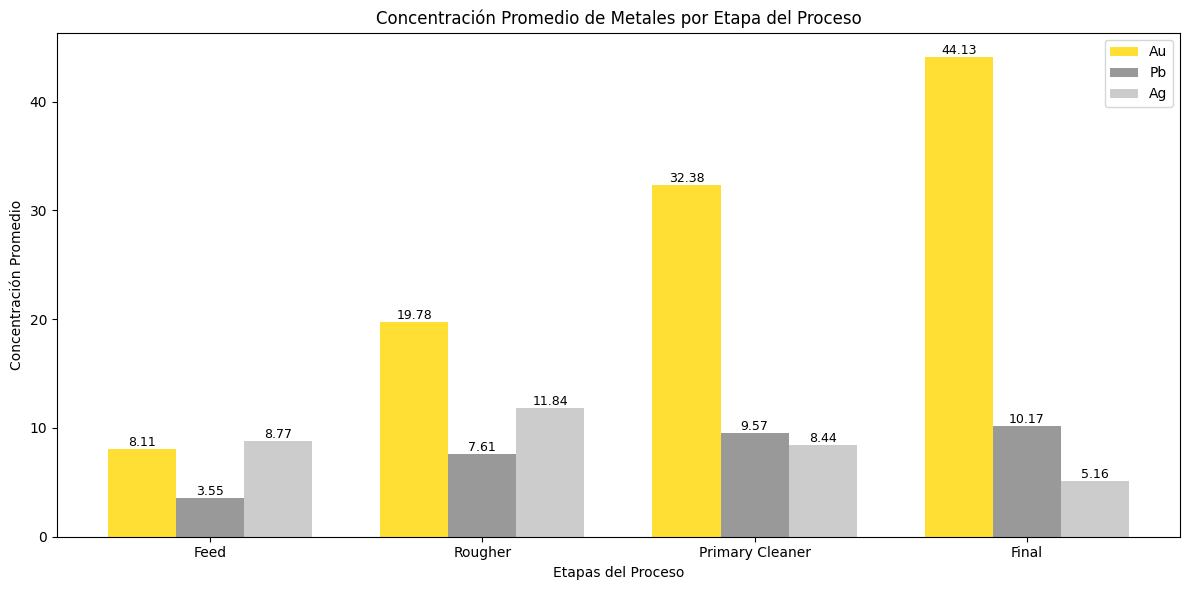

In [55]:
# Preparar datos para el gráfico
x = np.arange(len(etapas))  # Posiciones de las etapas en el eje X
width = 0.25  # Ancho de cada barra

# Extraer los promedios por metal
au_promedios = [promedios_por_etapa[etapa][0] for etapa in etapas]  # Au es índice 0
pb_promedios = [promedios_por_etapa[etapa][1] for etapa in etapas]  # Pb es índice 1
ag_promedios = [promedios_por_etapa[etapa][2] for etapa in etapas]  # Ag es índice 2

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Crear las barras agrupadas
bars1 = ax.bar(x - width, au_promedios, width, label='Au', color='gold', alpha=0.8)
bars2 = ax.bar(x, pb_promedios, width, label='Pb', color='gray', alpha=0.8)
bars3 = ax.bar(x + width, ag_promedios, width, label='Ag', color='silver', alpha=0.8)

# Personalizar el gráfico
ax.set_xlabel('Etapas del Proceso')
ax.set_ylabel('Concentración Promedio')
ax.set_title('Concentración Promedio de Metales por Etapa del Proceso')
ax.set_xticks(x)
ax.set_xticklabels(etapas)
ax.legend()

# Mostrar valores en las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Como el objetivo del proceso es extraer oro, es de esperar que la concentración vaya aumentando en cada etapa de limpieza y purificación.

Debido a que el plomo tiene tiene propiedades de flotación similares a la del oro, además de que los reativos utilizados no son completamente selectivos para el oro; este mineral tiende a concentrarse igualmente en el proceso.

Por otro lado, la plata tiene un comportamiento distinto a los minerales anteriores. Este se concentra en la etapa rougher porque tiene afinidad con los sulfuros. Luego, en las estapas de purificación es posible que disminuya dado que las condiciones se optimizan especificamente para purificar el oro.

***2.2.*** Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

In [56]:
# Verificar las columnas de tamaño de partículas
columnas_tamano = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

print("Verificando disponibilidad de columnas de tamaño:")
for col in columnas_tamano:
    en_entrenamiento = col in df_entrenamiento.columns
    en_prueba = col in df_prueba.columns
    print(f"{col}: Entrenamiento={en_entrenamiento}, Prueba={en_prueba}")

Verificando disponibilidad de columnas de tamaño:
rougher.input.feed_size: Entrenamiento=True, Prueba=True
primary_cleaner.input.feed_size: Entrenamiento=True, Prueba=True


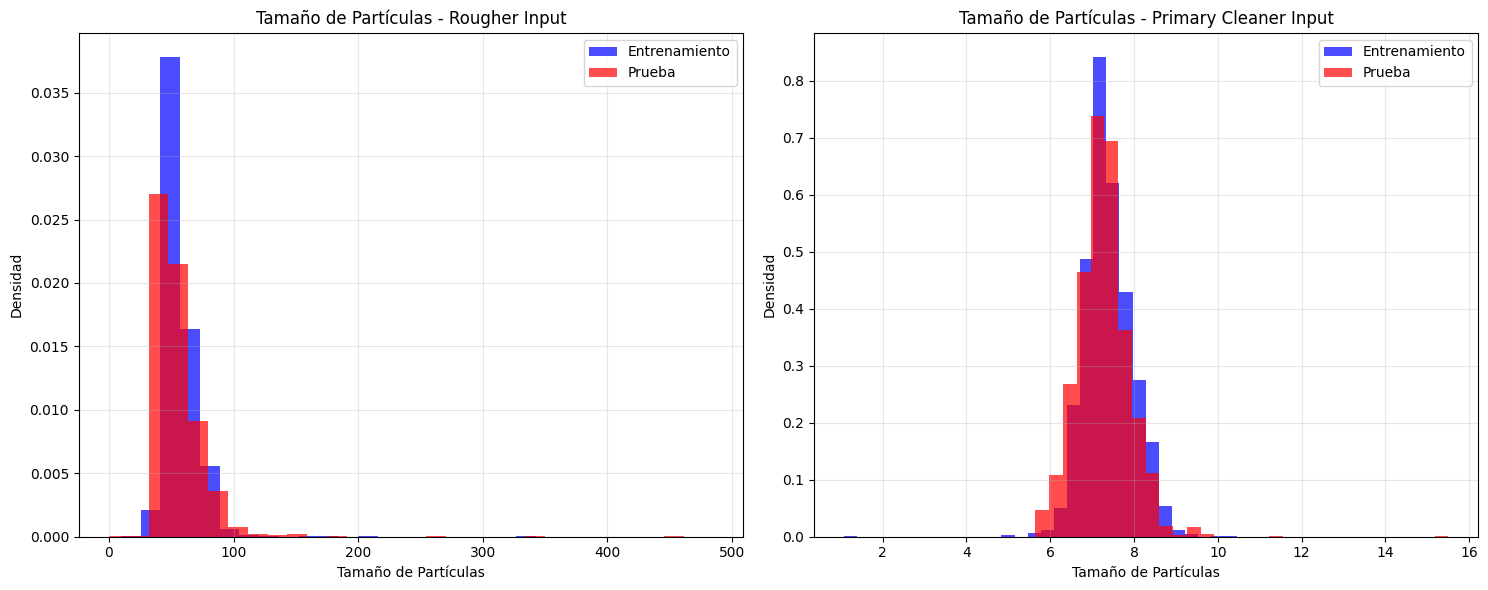

In [57]:
# Crear histogramas superpuestos para comparar distribuciones de tamaño de partículas
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Columnas de tamaño de partículas
columnas_tamano = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']
titulos = ['Tamaño de Partículas - Rougher Input', 'Tamaño de Partículas - Primary Cleaner Input']

for i, (col, titulo) in enumerate(zip(columnas_tamano, titulos)):
    # Histogramas superpuestos
    axes[i].hist(df_entrenamiento[col], bins=30, alpha=0.7, label='Entrenamiento', 
                 color='blue', density=True)
    axes[i].hist(df_prueba[col], bins=30, alpha=0.7, label='Prueba', 
                 color='red', density=True)
    
    axes[i].set_title(titulo)
    axes[i].set_xlabel('Tamaño de Partículas')
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

*Tamaño de partículas:*
durante el proceso de flotación se va reduciendo el tamaños por las coliciones con reactivos y entre partículas producto de la agitación mecánica.

*Densidad:*
Disminuye en el transcurso del proceso ya que el material se va concentrando y se van eliminando las colas.

*Rougher input:*
Hay diferencias significativas entre el datasets de entrenamiento y prueba, lo cual podría generar que las predicciones podrían ser menos confiables.

*Primary cleaner input:*
Los datos de entrenamiento y prueba son similares, solo se observan pequeñas diferencias, lo que sugiere que el modelo representará se mejor manera esta variable

**2.3.** Considera las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final. ¿Observas algún valor anormal en la distribución total? Si es así, ¿merece la pena eliminar esos valores de ambas muestras? Describe los resultados y elimina las anomalías.

In [58]:
# Calcular concentraciones totales para cada etapa

# 1. Materia prima (Feed) - solo disponible en entrenamiento
df_entrenamiento['feed_total'] = (
    df_entrenamiento['rougher.input.feed_au'] + 
    df_entrenamiento['rougher.input.feed_pb'] + 
    df_entrenamiento['rougher.input.feed_ag'] + 
    df_entrenamiento['rougher.input.feed_sol']
)

# 2. Concentrado rougher - solo disponible en entrenamiento
df_entrenamiento['rougher_concentrate_total'] = (
    df_entrenamiento['rougher.output.concentrate_au'] + 
    df_entrenamiento['rougher.output.concentrate_pb'] + 
    df_entrenamiento['rougher.output.concentrate_ag'] + 
    df_entrenamiento['rougher.output.concentrate_sol']
)

# 3. Concentrado final - solo disponible en entrenamiento
df_entrenamiento['final_concentrate_total'] = (
    df_entrenamiento['final.output.concentrate_au'] + 
    df_entrenamiento['final.output.concentrate_pb'] + 
    df_entrenamiento['final.output.concentrate_ag'] + 
    df_entrenamiento['final.output.concentrate_sol']
)

print("Concentraciones totales calculadas:")
print(f"Feed total - Media: {df_entrenamiento['feed_total'].mean():.2f}")
print(f"Rougher concentrate total - Media: {df_entrenamiento['rougher_concentrate_total'].mean():.2f}")
print(f"Final concentrate total - Media: {df_entrenamiento['final_concentrate_total'].mean():.2f}")


Concentraciones totales calculadas:
Feed total - Media: 56.99
Rougher concentrate total - Media: 67.90
Final concentrate total - Media: 69.06


La concentración de minerales aumenta durante el proceso porque se va retirando la ganga. Al final, se obtiene el mineral más puro, con la mayor concentración de minerales valiosos.

In [59]:
# Calcular estadísticas para cada concentración total
concentraciones = ['feed_total', 'rougher_concentrate_total', 'final_concentrate_total']

estadisticas = {}
for conc in concentraciones:
    media = df_entrenamiento[conc].mean()
    desv_std = df_entrenamiento[conc].std()
    
    # Límites para outliers usando regla 3-sigma (3 desviaciones estándar)
    limite_inferior = media - 3 * desv_std
    limite_superior = media + 3 * desv_std
    
    estadisticas[conc] = {
        'media': media,
        'desv_std': desv_std,
        'limite_inf': limite_inferior,
        'limite_sup': limite_superior
    }
    
    print(f"\n{conc.replace('_', ' ').title()}:")
    print(f"  Media: {media:.2f}")
    print(f"  Desviación estándar: {desv_std:.2f}")
    print(f"  Límites anómalos: [{limite_inferior:.2f}, {limite_superior:.2f}]")


Feed Total:
  Media: 56.99
  Desviación estándar: 6.55
  Límites anómalos: [37.35, 76.63]

Rougher Concentrate Total:
  Media: 67.90
  Desviación estándar: 12.24
  Límites anómalos: [31.16, 104.63]

Final Concentrate Total:
  Media: 69.06
  Desviación estándar: 5.99
  Límites anómalos: [51.09, 87.04]


La etapa de Rougher Concentrate es la que presenta una mayor desviación estándar porque es la etapa donde ocurre la mayor transformación, pues, el mineral pasa de su estado natural a un primer concentrado, separando minerales valiosos y ganga.

In [60]:
def eliminar_anomalias_multiples_variables(df, columnas_concentracion):
    """
    Elimina anomalías usando criterio 3-sigma para múltiples variables
    """
    df_limpio = df.copy()
    indices_a_eliminar = set()
    
    print("=== ANÁLISIS DE ANOMALÍAS POR VARIABLE ===")
    
    for columna in columnas_concentracion:
        if columna in df.columns:
            media = df[columna].mean()
            desv_std = df[columna].std()
            
            # Límites 3-sigma
            limite_inferior = media - 3 * desv_std
            limite_superior = media + 3 * desv_std
            
            # Identificar índices anómalos
            anomalos = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)].index
            indices_a_eliminar.update(anomalos)
            
            print(f"\n{columna}:")
            print(f"  Anomalías encontradas: {len(anomalos)} ({len(anomalos)/len(df)*100:.2f}%)")
            print(f"  Rango normal: [{limite_inferior:.2f}, {limite_superior:.2f}]")
    
    # Eliminar todas las filas con anomalías
    df_limpio = df_limpio.drop(indices_a_eliminar)
    
    print(f"\n=== RESUMEN FINAL ===")
    print(f"Datos originales: {len(df)}")
    print(f"Filas con anomalías (total): {len(indices_a_eliminar)}")
    print(f"Datos después de filtrar: {len(df_limpio)}")
    print(f"Porcentaje eliminado: {len(indices_a_eliminar)/len(df)*100:.2f}%")
    
    return df_limpio

In [61]:
# Variables de concentración de todas las etapas
columnas_concentracion = [
    'feed_total',
    'rougher_concentrate_total', 
    'final_concentrate_total'
]

# Aplicar la limpieza
df_entrenamiento_limpio = eliminar_anomalias_multiples_variables(df_entrenamiento, columnas_concentracion)

=== ANÁLISIS DE ANOMALÍAS POR VARIABLE ===

feed_total:
  Anomalías encontradas: 99 (0.90%)
  Rango normal: [37.35, 76.63]

rougher_concentrate_total:
  Anomalías encontradas: 239 (2.17%)
  Rango normal: [31.16, 104.63]

final_concentrate_total:
  Anomalías encontradas: 136 (1.23%)
  Rango normal: [51.09, 87.04]

=== RESUMEN FINAL ===
Datos originales: 11017
Filas con anomalías (total): 424
Datos después de filtrar: 10593
Porcentaje eliminado: 3.85%


Muchos de los valores anómalos son 0 o muy bajos, por lo que podrían tratarse de paradas de planta o periodos de mantenimiento. Se eliminaron estos datos ya que representan un cantidad muy baja según la regla 3 sigma.

**Construye el modelo**

**3.1.** Escribe una función para calcular el valor final de sMAPE.

In [62]:
def smape(y_true, y_pred):

    # Paso 1: Calcular la diferencia absoluta
    diferencia_absoluta = np.abs(y_true - y_pred)
    
    return diferencia_absoluta  # Por ahora solo retornamos esto

In [63]:
# Valores de prueba
y_true = np.array([10, 20, 30])
y_pred = np.array([12, 18, 32])

resultado = smape(y_true, y_pred)
print(resultado)

[2 2 2]


In [64]:
def smape(y_true, y_pred):
    # Paso 1: Calcular la diferencia absoluta
    diferencia_absoluta = np.abs(y_true - y_pred)
    
    # Paso 2: Calcular el denominador
    denominador = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    print(f"Diferencia absoluta: {diferencia_absoluta}")
    print(f"Denominador: {denominador}")
    
    return diferencia_absoluta, denominador  # Retornamos ambos por ahora

In [65]:
y_true = np.array([10, 20, 30])
y_pred = np.array([12, 18, 32])

resultado = smape(y_true, y_pred)

Diferencia absoluta: [2 2 2]
Denominador: [11. 19. 31.]


In [66]:
def smape(y_true, y_pred):

    # Paso 1: Calcular la diferencia absoluta
    diferencia_absoluta = np.abs(y_true - y_pred)
    
    # Paso 2: Calcular el denominador
    denominador = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Paso 3: Dividir y calcular el promedio
    errores_relativos = diferencia_absoluta / denominador
    smape_valor = np.mean(errores_relativos) * 100
    
    print(f"Errores relativos: {errores_relativos}")
    print(f"sMAPE final: {smape_valor}%")
    
    return smape_valor

In [67]:
y_true = np.array([10, 20, 30])
y_pred = np.array([12, 18, 32])

resultado = smape(y_true, y_pred)

Errores relativos: [0.18181818 0.10526316 0.06451613]
sMAPE final: 11.719915624839224%


In [68]:
def smape(y_true, y_pred):
    # Paso 1: Calcular la diferencia absoluta
    diferencia_absoluta = np.abs(y_true - y_pred)
    
    # Paso 2: Calcular el denominador
    denominador = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Paso 3: Dividir y calcular el promedio
    errores_relativos = diferencia_absoluta / denominador
    smape_valor = np.mean(errores_relativos) * 100
    
    print(f"Diferencia absoluta: {diferencia_absoluta}")
    print(f"Denominador: {denominador}")
    print(f"Errores relativos: {errores_relativos}")
    print(f"sMAPE final: {smape_valor}%")
    
    return smape_valor

# Prueba
y_true = np.array([10, 20, 30])
y_pred = np.array([12, 18, 32])
resultado = smape(y_true, y_pred)

Diferencia absoluta: [2 2 2]
Denominador: [11. 19. 31.]
Errores relativos: [0.18181818 0.10526316 0.06451613]
sMAPE final: 11.719915624839224%


11,72% es el promedio de los errores relativos de las tres muestras realizadas con valores ficticios para explicar cómo opera la función.

**3.2.** Entrena diferentes modelos. Evalúalos aplicando la validación cruzada. Elige el mejor modelo y pruébalo utilizando la muestra de prueba. Facilita los resultados.

Utiliza estas fórmulas para las métricas de evaluación: sMAPE y sMAPE final

Para modelar los datos, se considerarán 'rougher.output.recovery' y 'final.output.recovery' como variables objetivo, y todas las demás columnas comunes entre el dataset de entrenamiento y prueba, excepto date, serán para construir el modelo.

In [69]:
# Definir variables objetivo
variables_objetivo = ['rougher.output.recovery', 'final.output.recovery']

# Obtener las columnas comunes entre entrenamiento y prueba (ya las calculaste antes)
variables_comunes = columnas_entrenamiento.intersection(columnas_prueba)

# Variables comunes (características) - excluir 'date' y variables objetivo
caracteristicas = [col for col in variables_comunes 
                  if col != 'date' and col not in variables_objetivo]

print(f"Número de características disponibles: {len(caracteristicas)}")
print(f"Variables objetivo: {variables_objetivo}")

Número de características disponibles: 52
Variables objetivo: ['rougher.output.recovery', 'final.output.recovery']


In [70]:
# Usar el dataset de entrenamiento limpio
df_train = df_entrenamiento_limpio

# X: Todas las características (52 variables)
X = df_train[caracteristicas]

# y: Las dos variables objetivo por separado
y_rougher = df_train['rougher.output.recovery']
y_final = df_train['final.output.recovery']

Para construir un modelo que busca predecir dos variables, se ocupará RandomForest y DecisionTree.

In [71]:
# X: Todas las características (52 variables)
X = df_train[caracteristicas]

# y: Ambas variables objetivo juntas como matriz
y = df_train[['rougher.output.recovery', 'final.output.recovery']]

# División 75% entrenamiento, 25% validación
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42
)

In [72]:
# Inicializar el StandardScaler
scaler = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [73]:
# Inicializar el modelo RandomForest
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Usar todos los cores disponibles
)

# Entrenar el modelo con ambas variables objetivo
rf_model.fit(X_train_scaled, y_train)

# Hacer predicciones en validación
y_pred_rf = rf_model.predict(X_val_scaled)

print("Entrenamiento completado")
print(f"Predicciones para rougher: {y_pred_rf[:, 0][:5]}")
print(f"Predicciones para final: {y_pred_rf[:, 1][:5]}")

Entrenamiento completado
Predicciones para rougher: [89.71455769 84.22685965 67.89211126 80.85148223 90.583711  ]
Predicciones para final: [68.08142304 68.18791134 50.16384094 65.46534036 74.28745805]


In [74]:
# Calcular sMAPE para cada variable objetivo
smape_rougher = smape(y_val.iloc[:, 0], y_pred_rf[:, 0])
smape_final = smape(y_val.iloc[:, 1], y_pred_rf[:, 1])

# sMAPE promedio (como requiere el proyecto)
smape_promedio = (smape_rougher + smape_final) / 2

print(f"sMAPE Rougher Recovery: {smape_rougher:.4f}")
print(f"sMAPE Final Recovery: {smape_final:.4f}")
print(f"sMAPE Promedio: {smape_promedio:.4f}")


Diferencia absoluta: 11150    2.836428
14697    1.793703
2713     3.011038
10270    2.990462
16825    1.068394
           ...   
4428     2.180927
11227    0.442175
6027     1.914581
614      4.679838
15096    0.651747
Name: rougher.output.recovery, Length: 2649, dtype: float64
Denominador: 11150    91.132772
14697    85.123711
2713     66.386592
10270    79.356251
16825    90.049514
           ...    
4428     89.106620
11227    83.409254
6027     87.786746
614      76.700875
15096    91.542786
Name: rougher.output.recovery, Length: 2649, dtype: float64
Errores relativos: 11150    0.031124
14697    0.021072
2713     0.045356
10270    0.037684
16825    0.011865
           ...   
4428     0.024475
11227    0.005301
6027     0.021809
614      0.061014
15096    0.007120
Name: rougher.output.recovery, Length: 2649, dtype: float64
sMAPE final: 2.3689805982205505%
Diferencia absoluta: 11150    0.806679
14697    1.317986
2713     4.146728
10270    0.108331
16825    0.209015
           ...   


Un sMAPE promedio de 3,55% (menor a 5%) representa un excelente rendimiento del modelo; éste es más preciso en la etapa de Rougher Rcovery, mientras que presenta un mayor error en Final Recovery.

In [75]:
# Crear el modelo base Decision Tree
dt_model = DecisionTreeRegressor(
    random_state=42,  # Para reproducibilidad
    max_depth=10,     # Evitar overfitting
    min_samples_split=20,  # Mínimo de muestras para dividir
    min_samples_leaf=10    # Mínimo de muestras en hoja
)

# Envolver para múltiples salidas
dt_multi = MultiOutputRegressor(dt_model)

In [76]:
# Entrenar el modelo
dt_multi.fit(X_train_scaled, y_train)

# Hacer predicciones (usar X_val_scaled, no X_test_scaled)
y_pred_dt = dt_multi.predict(X_val_scaled)

In [77]:
# Calcular sMAPE para Decision Tree
smape_rougher_dt = smape(y_val.iloc[:, 0], y_pred_dt[:, 0])
smape_final_dt = smape(y_val.iloc[:, 1], y_pred_dt[:, 1])
smape_promedio_dt = (smape_rougher_dt + smape_final_dt) / 2

print(f"Decision Tree - sMAPE Rougher: {smape_rougher_dt:.4f}")
print(f"Decision Tree - sMAPE Final: {smape_final_dt:.4f}")
print(f"Decision Tree - sMAPE Promedio: {smape_promedio_dt:.4f}")

Diferencia absoluta: 11150    1.304953
14697    4.664256
2713     3.879414
10270    0.548015
16825    3.060637
           ...   
4428     0.940668
11227    2.534252
6027     0.048237
614      2.019305
15096    2.097638
Name: rougher.output.recovery, Length: 2649, dtype: float64
Denominador: 11150    91.898509
14697    83.688434
2713     66.820780
10270    77.587013
16825    91.045635
           ...    
4428     89.726749
11227    82.363216
6027     86.853574
614      75.370608
15096    92.917479
Name: rougher.output.recovery, Length: 2649, dtype: float64
Errores relativos: 11150    0.014200
14697    0.055734
2713     0.058057
10270    0.007063
16825    0.033617
           ...   
4428     0.010484
11227    0.030769
6027     0.000555
614      0.026792
15096    0.022575
Name: rougher.output.recovery, Length: 2649, dtype: float64
sMAPE final: 3.0365554066789198%
Diferencia absoluta: 11150    1.749198
14697    7.978283
2713     5.465435
10270    2.983935
16825    4.798519
           ...   


Un sMAPE promedio de 4,5% es un excelente resultado (menor a 5%), siendo mejor el rendimiento en Rougher Recovery que en Final Recovery.

Finalmente, es posible decir que Random Forest superó el rendimiento de Decision Tree al tener un sMAPE promedio menor.

Para hacer una evaluación más robusta, se procederá a realizar una validación cruzada, usando TimeSeriesSplir con 5 pliegues.

In [78]:

# Función personalizada para sMAPE en validación cruzada
def smape_scorer(y_true, y_pred):
    if y_pred.ndim == 1:  # Una sola salida
        return -smape(y_true, y_pred)  # Negativo porque sklearn maximiza
    else:  # Múltiples salidas
        smape_rougher = smape(y_true[:, 0], y_pred[:, 0])
        smape_final = smape(y_true[:, 1], y_pred[:, 1])
        return -((smape_rougher + smape_final) / 2)  # sMAPE promedio negativo

# Crear scorer personalizado
from sklearn.metrics import make_scorer
smape_custom_scorer = make_scorer(smape_scorer, greater_is_better=False)


In [79]:
# Configurar Time Series Split con 5 pliegues
tscv = TimeSeriesSplit(n_splits=5)

In [80]:
# Preparar datos completos para validación cruzada
X_completo = df_entrenamiento_limpio[caracteristicas]
y_completo = df_entrenamiento_limpio[['rougher.output.recovery', 'final.output.recovery']]

print("Datos completos para validación cruzada:")
print(f"X_completo: {X_completo.shape}")
print(f"y_completo: {y_completo.shape}")

Datos completos para validación cruzada:
X_completo: (10593, 52)
y_completo: (10593, 2)


In [81]:
# Configurar Time Series Split con 5 pliegues
tscv = TimeSeriesSplit(n_splits=5)
print(f"Time Series Split configurado con {tscv.n_splits} pliegues")

# Verificar cómo se dividen los datos
print("\nTamaños de cada pliegue:")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_completo)):
    print(f"Pliegue {i+1}: Train={len(train_idx)}, Validación={len(val_idx)}")

Time Series Split configurado con 5 pliegues

Tamaños de cada pliegue:
Pliegue 1: Train=1768, Validación=1765
Pliegue 2: Train=3533, Validación=1765
Pliegue 3: Train=5298, Validación=1765
Pliegue 4: Train=7063, Validación=1765
Pliegue 5: Train=8828, Validación=1765


In [82]:
# Crear escalador para los datos completos
scaler_completo = StandardScaler()

# Listas para almacenar resultados
resultados_rf = []
resultados_dt = []


In [83]:
# Ejecutar validación cruzada
for i, (train_idx, val_idx) in enumerate(tscv.split(X_completo)):
    print(f"\nPliegue {i+1}/5:")
    
    # Dividir datos
    X_train_fold = X_completo.iloc[train_idx]
    X_val_fold = X_completo.iloc[val_idx]
    y_train_fold = y_completo.iloc[train_idx]
    y_val_fold = y_completo.iloc[val_idx]
    
    # Escalar datos
    X_train_scaled = scaler_completo.fit_transform(X_train_fold)
    X_val_scaled = scaler_completo.transform(X_val_fold)
    
    # Entrenar y evaluar RandomForest
    rf_fold = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_fold.fit(X_train_scaled, y_train_fold)
    y_pred_rf = rf_fold.predict(X_val_scaled)
    
    # Calcular sMAPE para RandomForest
    smape_rougher_rf = smape(y_val_fold.iloc[:, 0], y_pred_rf[:, 0])
    smape_final_rf = smape(y_val_fold.iloc[:, 1], y_pred_rf[:, 1])
    smape_promedio_rf = (smape_rougher_rf + smape_final_rf) / 2
    
    resultados_rf.append({
        'pliegue': i+1,
        'smape_rougher': smape_rougher_rf,
        'smape_final': smape_final_rf,
        'smape_promedio': smape_promedio_rf
    })
    
    print(f"  RandomForest - sMAPE promedio: {smape_promedio_rf:.4f}")


Pliegue 1/5:
Diferencia absoluta: 2688     2.049783
2689     1.173915
2690     3.084630
2691     6.221630
2692     6.912868
          ...    
4850     9.677066
4851     5.880782
4852     9.864342
4853     9.499707
4854    13.724580
Name: rougher.output.recovery, Length: 1765, dtype: float64
Denominador: 2688    79.059077
2689    79.680857
2690    81.247632
2691    78.383179
2692    79.503439
          ...    
4850    75.347877
4851    77.430861
4852    75.100167
4853    75.426174
4854    73.144599
Name: rougher.output.recovery, Length: 1765, dtype: float64
Errores relativos: 2688    0.025927
2689    0.014733
2690    0.037966
2691    0.079375
2692    0.086951
          ...   
4850    0.128432
4851    0.075949
4852    0.131349
4853    0.125947
4854    0.187636
Name: rougher.output.recovery, Length: 1765, dtype: float64
sMAPE final: 6.873898884120311%
Diferencia absoluta: 2688     2.522620
2689     3.032213
2690     6.941278
2691     9.403503
2692    12.700863
          ...    
4850     

In [84]:
# Reiniciar el bucle completo para incluir ambos modelos
resultados_rf = []
resultados_dt = []

print("Validación cruzada completa - RandomForest y DecisionTree:")
print("=" * 60)

for i, (train_idx, val_idx) in enumerate(tscv.split(X_completo)):
    print(f"\nPliegue {i+1}/5:")
    
    # Dividir datos
    X_train_fold = X_completo.iloc[train_idx]
    X_val_fold = X_completo.iloc[val_idx]
    y_train_fold = y_completo.iloc[train_idx]
    y_val_fold = y_completo.iloc[val_idx]
    
    # Escalar datos
    scaler_fold = StandardScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_scaled = scaler_fold.transform(X_val_fold)
    
    # RandomForest
    rf_fold = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_fold.fit(X_train_scaled, y_train_fold)
    y_pred_rf = rf_fold.predict(X_val_scaled)
    
    smape_rougher_rf = smape(y_val_fold.iloc[:, 0], y_pred_rf[:, 0])
    smape_final_rf = smape(y_val_fold.iloc[:, 1], y_pred_rf[:, 1])
    smape_promedio_rf = (smape_rougher_rf + smape_final_rf) / 2
    
    # DecisionTree
    dt_fold = DecisionTreeRegressor(random_state=42)
    dt_fold.fit(X_train_scaled, y_train_fold)
    y_pred_dt = dt_fold.predict(X_val_scaled)
    
    smape_rougher_dt = smape(y_val_fold.iloc[:, 0], y_pred_dt[:, 0])
    smape_final_dt = smape(y_val_fold.iloc[:, 1], y_pred_dt[:, 1])
    smape_promedio_dt = (smape_rougher_dt + smape_final_dt) / 2
    
    # Guardar resultados
    resultados_rf.append({
        'pliegue': i+1,
        'smape_rougher': smape_rougher_rf,
        'smape_final': smape_final_rf,
        'smape_promedio': smape_promedio_rf
    })
    
    resultados_dt.append({
        'pliegue': i+1,
        'smape_rougher': smape_rougher_dt,
        'smape_final': smape_final_dt,
        'smape_promedio': smape_promedio_dt
    })
    
    print(f"  RandomForest - sMAPE promedio: {smape_promedio_rf:.4f}")
    print(f"  DecisionTree - sMAPE promedio: {smape_promedio_dt:.4f}")

Validación cruzada completa - RandomForest y DecisionTree:

Pliegue 1/5:
Diferencia absoluta: 2688     2.049783
2689     1.173915
2690     3.084630
2691     6.221630
2692     6.912868
          ...    
4850     9.677066
4851     5.880782
4852     9.864342
4853     9.499707
4854    13.724580
Name: rougher.output.recovery, Length: 1765, dtype: float64
Denominador: 2688    79.059077
2689    79.680857
2690    81.247632
2691    78.383179
2692    79.503439
          ...    
4850    75.347877
4851    77.430861
4852    75.100167
4853    75.426174
4854    73.144599
Name: rougher.output.recovery, Length: 1765, dtype: float64
Errores relativos: 2688    0.025927
2689    0.014733
2690    0.037966
2691    0.079375
2692    0.086951
          ...   
4850    0.128432
4851    0.075949
4852    0.131349
4853    0.125947
4854    0.187636
Name: rougher.output.recovery, Length: 1765, dtype: float64
sMAPE final: 6.873898884120311%
Diferencia absoluta: 2688     2.522620
2689     3.032213
2690     6.941278
2691

Los resultados muestran que Random Forest es superior a DecisionTree, con una diferencia de 4.2 puntos. El primero tiene un resultado de alrededor del 7%, que es bueno, mientras que el segundo tiene un rendimiento en torno al 11%, lo cual es aceptable pero inferior.

Se observa que RandomForest es más estable entre pliegues, mientras que DecisionTree tiene mayor variabilidad (especialmente entre los pliegues 4-5).

Por tanton la validación cruzada con TimeSeriesSplit confirma que RandomForest mantiene mejor rendimiento a través del tiempo. Y se procederá a evaluar este modelo en el conjunto de prueba final.

In [87]:
# Preparar el conjunto de prueba
X_test = df_prueba[caracteristicas]

# Escalar usando el mismo scaler del entrenamiento
X_test_scaled = scaler_final.transform(X_test)

print(f"Datos de prueba preparados: {X_test.shape}")
print(f"Características utilizadas: {len(caracteristicas)}")

Datos de prueba preparados: (5383, 52)
Características utilizadas: 52


In [88]:
# Hacer predicciones en el conjunto de prueba
y_pred_test = rf_final.predict(X_test_scaled)

print("Predicciones realizadas en el conjunto de prueba")
print(f"Forma de las predicciones: {y_pred_test.shape}")
print(f"\nPrimeras 5 predicciones:")
print(f"Rougher Recovery: {y_pred_test[:5, 0]}")
print(f"Final Recovery: {y_pred_test[:5, 1]}")

Predicciones realizadas en el conjunto de prueba
Forma de las predicciones: (5383, 2)

Primeras 5 predicciones:
Rougher Recovery: [90.1309094  89.64299349 89.08961774 88.39586104 87.3365204 ]
Final Recovery: [70.11328723 70.18660331 69.92974517 70.18179093 69.70302726]


In [89]:
# Crear DataFrame con las predicciones para análisis
df_predicciones = pd.DataFrame({
    'rougher_recovery_pred': y_pred_test[:, 0],
    'final_recovery_pred': y_pred_test[:, 1]
})

# Estadísticas descriptivas
print("=== ESTADÍSTICAS DE LAS PREDICCIONES ===")
print(df_predicciones.describe())

# Comparar con estadísticas del conjunto de entrenamiento
print("\n=== COMPARACIÓN CON DATOS DE ENTRENAMIENTO ===")
print("Rougher Recovery:")
print(f"  Entrenamiento - Media: {y_train_final['rougher.output.recovery'].mean():.2f}")
print(f"  Predicciones - Media: {df_predicciones['rougher_recovery_pred'].mean():.2f}")

print("Final Recovery:")
print(f"  Entrenamiento - Media: {y_train_final['final.output.recovery'].mean():.2f}")
print(f"  Predicciones - Media: {df_predicciones['final_recovery_pred'].mean():.2f}")

=== ESTADÍSTICAS DE LAS PREDICCIONES ===
       rougher_recovery_pred  final_recovery_pred
count            5383.000000          5383.000000
mean               83.661912            66.716711
std                 4.415089             4.215835
min                63.408030            46.978718
25%                81.216008            64.271647
50%                83.536819            67.067067
75%                85.815803            69.753023
max                93.736793            77.112581

=== COMPARACIÓN CON DATOS DE ENTRENAMIENTO ===
Rougher Recovery:
  Entrenamiento - Media: 84.44
  Predicciones - Media: 83.66
Final Recovery:
  Entrenamiento - Media: 67.12
  Predicciones - Media: 66.72


Las medias en ambas etapas es similar, por tanto, el modelo predice valores realistas.

La distribución de las predicciones poseen variabilidad normal, es consistente con el proceso real.

Es posible decir que las predicciones se encuentran centradas correctamente, con valores overfitting. Todas las predicciones están dentro de rangos técnicamente factibles.